# HumanForYou 


Dans un contexte de mondialisation et de concurrence accrue, les entreprises sont confrontées à des défis majeurs en matière de gestion des ressources humaines. L'entreprise pharmaceutique HumanForYou, basée en Inde, illustre parfaitement ces enjeux. Avec un effectif de 4000 employés, elle fait face à un taux de rotation annuel d'environ 15 %, un phénomène qui soulève des préoccupations significatives au sein de la direction. Ce taux élevé de turnover affecte non seulement la continuité des projets et la réputation de l'entreprise, mais impose également une pression constante sur le service des ressources humaines pour remplacer les départs par de nouveaux talents, tout en entraînant des coûts de formation et d'intégration considérables pour les nouveaux arrivants.

# Problématique

### Identification des facteurs de rotation

- Quels sont les principaux facteurs contribuant au taux élevé de rotation des employés ? 



### Prédiction de l'attrition

- Comment prédire quels employés sont les plus susceptibles de quitter l'entreprise ?

## Portée des Données pour l'Analyse chez HumanForYou

**Données Principales :**
- **Nombre total d'employés :** 4 410.

**Jeux de Données au Format CSV :**
- **Informations Générales sur les Employés :** `general_data`
- **Données de l'Enquête de Satisfaction des Employés :** `employee_survey_data`
- **Évaluations des Managers :** `manager_survey_data`
- **Heures d'Arrivée au Bureau :** `in_time`
- **Heures de Départ du Bureau :** `out_time`


## Stratégie d'Intervention

Pour aborder les questions soulevées, la stratégie suivante a été élaborée :
- **Étape 1 :** Préparation et nettoyage des données.
- **Étape 2 :** Clarification des indicateurs clés.
- **Étape 3 :** Formation des modèles prédictifs.
- **Étape 4 :** Analyse et compréhension des résultats obtenus.


## Importation des librairies

Nous allons commencer par importer les librairies nécessaires pour effectuer notre analyse.

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, uuid
from sklearn.pipeline import Pipeline
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from io import BytesIO
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
warnings.filterwarnings('ignore')
from pycaret.classification import *
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
sns.set()

## Importation des données

Nous allons maintenant importer les données nécessaires pour effectuer notre analyse. Ces données sont stockées dans un conteneur Azure Blob Storage où les données fournies par HumanForYou sont stockées pour une question de securité des données. Nous allons utiliser la bibliothèque `azure-storage-blob` pour télécharger ces données. Dans un premier temps, nous créons une connexion au conteneur de stockage Azure Blob à partir de la chaine de connexion stockée dans une variable d'environnement. Ensuite, nous utilisons cette connexion pour télécharger les données dans des dataframes pandas grâce à la bibliothèque `pandas`.

## Connexion à Azure

In [29]:
connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client("data")

## Récupération des données

In [30]:
def download_blob_to_df(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    download_stream = blob_client.download_blob()
    blob_data = BytesIO(download_stream.readall())
    return pd.read_csv(blob_data)

In [55]:
in_time_df = download_blob_to_df("in_time.csv")
manager_survey_data_df = download_blob_to_df("manager_survey_data.csv")
employee_survey_data_df = download_blob_to_df("employee_survey_data.csv")
out_time_df = download_blob_to_df("out_time.csv")
general_data_df = download_blob_to_df("general_data.csv")

## Merge des données

Une fois que nous avons chargé les données, nous allons les fusionner en une seule dataframe pour faciliter leur manipulation. Avant cela, nous allons faire une analyse exploratoire des données pour comprendre la structure des données et identifier les problèmes potentiels.

In [56]:
general_data_df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


Nous remarquons que certaines colonnes sont de type catégorielle et que d'autres sont de type numérique. Nous remarquons également que certaines colonnes contiennent des valeurs manquantes. 

In [57]:
manager_survey_data_df.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [58]:
employee_survey_data_df.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [59]:
in_time_df.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [60]:
out_time_df.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


On remarque que tout ces jeux de données sont liés par la colonne `EmployeeID`. Nous allons donc fusionner ces jeux de données en une seule dataframe pour faciliter leur manipulation. 

In [61]:
human_for_you_df = pd.merge(general_data_df, manager_survey_data_df, on = 'EmployeeID', how = 'inner')
human_for_you_df = pd.merge(human_for_you_df, employee_survey_data_df, on = 'EmployeeID', how = 'inner')

## Gestion des horaires

Les fichiers `in_time` et `out_time` contiennent les heures d'arrivée et de départ des employés. Nous allons les utiliser pour calculer la durée de présence de chaque employé. Cependant ces données nécessitent un traitement particulier avant de les merger avec les autres données.
Les données en l'état ne sont pas utiles, nous allons donc les transformer pour les rendre exploitables.

*  Remplacer les valeurs manquantes par 0.
*  Renommage de la colonne 'Unnamed: 0' qui correspond à `L'EmployeeID`.
*  Conversion des colonnes en format datetime grâce à la fonction `pd.to_datetime` de pandas.
*  Calcul du nombres d'heures par jour de notre employé.

Afin de pouvoir traiter les heures d'arrivées et de départ, nous allons créer un nouvel indicateur `PresenceIndicator` qui nous permettra de savoir si l'employé respecte son temps de travail inscrit dans son contrat. A noter que le temps de travail inscrit dans le contrat des employés de HumanForYou est de 8 heures par jour pour tout les employés. Si l'employé travaille au moins 8 heures par jour, la valeur de `PresenceIndicator` sera de 1, sinon elle sera de 0 pour le jour donné. Nous faisons ensuite une somme de l'indicateur pour tous les jours, ce qui nous donne un score de présence pour chaque employé.

In [62]:
def transform_time_data(in_time, out_time):
    in_time.rename(columns={'Unnamed: 0':'EmployeeID'}, inplace=True)
    out_time.rename(columns={'Unnamed: 0':'EmployeeID'}, inplace=True)

    employee_id_index = in_time['EmployeeID']
    for col in in_time.columns:
        in_time[col] = pd.to_datetime(in_time[col], errors='coerce')

    for col in out_time.columns:
        out_time[col] = pd.to_datetime(out_time[col], errors='coerce')

    daily_hours = (out_time - in_time).applymap(lambda x: x.total_seconds() / 3600)
    daily_hours = daily_hours.fillna(0)
    daily_hours['PresenceIndicator'] = daily_hours.iloc[:, 1:].apply(lambda row: sum(1 if hours >= 8 else 0 for hours in row), axis=1)

    presence_indicator = pd.DataFrame({'EmployeeID': employee_id_index, 'PresenceIndicator': daily_hours['PresenceIndicator']})

    return presence_indicator

Nous allons maintenant appliquer cette fonction à nos données.

In [63]:
presence_indicator = transform_time_data(in_time_df, out_time_df)

Nous allons maintenant merger ces données avec notre dataframe principale.

In [64]:
human_for_you_df = pd.merge(human_for_you_df, presence_indicator, on = 'EmployeeID', how = 'inner')

Nous avons maintenant une dataframe qui contient toutes les informations nécessaires pour effectuer notre analyse. Nous allons maintenant nettoyer nos données avant de les analyser.

# Nettoyage des données

Nous allons vérifier à l'aide de la fonction `info` de pandas si nos données sont propres et s'il n'y a pas de valeurs manquantes.

In [65]:
human_for_you_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Nous remarquons que certaines colonnes contiennent des valeurs manquantes. Nous allons les remplacer par la médiane de la colonne afin de ne pas fausser nos analyses. Le remplissage des valeurs manquantes par la médiane est privilégié pour sa robustesse aux valeurs aberrantes et son aptitude à préserver la distribution originale des données, même en présence d'asymétrie.

In [66]:
environmentSatisfactionMedian = human_for_you_df.EnvironmentSatisfaction.median()
jobSatisfactionMedian = human_for_you_df.JobSatisfaction.median()
workLifeBalanceMedian = human_for_you_df.WorkLifeBalance.median()
totalWorkingYears_median = human_for_you_df['TotalWorkingYears'].median()
numCompaniesWorked_median = human_for_you_df['NumCompaniesWorked'].median()

In [67]:
human_for_you_df['EnvironmentSatisfaction'].fillna(environmentSatisfactionMedian, inplace = True)
human_for_you_df['JobSatisfaction'].fillna(jobSatisfactionMedian, inplace = True)
human_for_you_df['WorkLifeBalance'].fillna(workLifeBalanceMedian, inplace = True)
human_for_you_df['TotalWorkingYears'].fillna(totalWorkingYears_median, inplace = True)
human_for_you_df['NumCompaniesWorked'].fillna(numCompaniesWorked_median, inplace = True)

Nous pouvons vérifier si nos données sont propres.

In [68]:
human_for_you_df.isnull().sum()

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
PresenceIndicator          0
dtype: int64

Toutes nos données ont été nettoyées. Nous allons maintenant effectuer une analyse exploratoire de nos données pour comprendre la structure de nos données et identifier les problèmes potentiels.

# Analyse exploratoire des données

Dans le cadre de l'analyse de nos données, nous nous sommes rendu compte que certaines données ne doivent pas ou n'ont pas d'intérer à être anlyser.

Dans une optique éthique certains données sont problèmatique :
- MaritalStatus
- Gender
- Age
- Over18


In [69]:
human_for_you_df.drop(columns=['Over18', 'MaritalStatus', 'Gender', 'Age'], inplace=True)

Une fois que ces données sont supprimées, nous pouvons commencer par analyser la distribution de nos données. Nous allons commencer par analyser la distribution de notre variable cible `Attrition` pour comprendre la distribution de nos données.

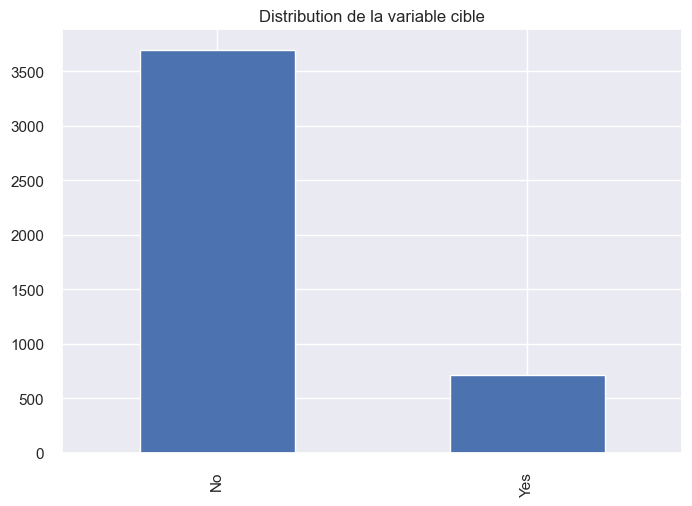

In [70]:
human_for_you_df['Attrition'].value_counts().plot(kind='bar')
plt.title('Distribution de la variable cible')
plt.show()

Nous remarquons aisément que les classes ne sont pas équilibrées, ce qui peut poser problème lors de l'entraînement de nos modèles de machine learning. C'est un point important qu'il faut prendre en compte. Nous allons maintenant analyser la distribution de nos autres variables grâce à un histogramme de la bibliothèque `pandas`.

array([[<AxesSubplot: title={'center': 'DistanceFromHome'}>,
        <AxesSubplot: title={'center': 'Education'}>,
        <AxesSubplot: title={'center': 'EmployeeCount'}>,
        <AxesSubplot: title={'center': 'EmployeeID'}>,
        <AxesSubplot: title={'center': 'JobLevel'}>],
       [<AxesSubplot: title={'center': 'MonthlyIncome'}>,
        <AxesSubplot: title={'center': 'NumCompaniesWorked'}>,
        <AxesSubplot: title={'center': 'PercentSalaryHike'}>,
        <AxesSubplot: title={'center': 'StandardHours'}>,
        <AxesSubplot: title={'center': 'StockOptionLevel'}>],
       [<AxesSubplot: title={'center': 'TotalWorkingYears'}>,
        <AxesSubplot: title={'center': 'TrainingTimesLastYear'}>,
        <AxesSubplot: title={'center': 'YearsAtCompany'}>,
        <AxesSubplot: title={'center': 'YearsSinceLastPromotion'}>,
        <AxesSubplot: title={'center': 'YearsWithCurrManager'}>],
       [<AxesSubplot: title={'center': 'JobInvolvement'}>,
        <AxesSubplot: title={'cente

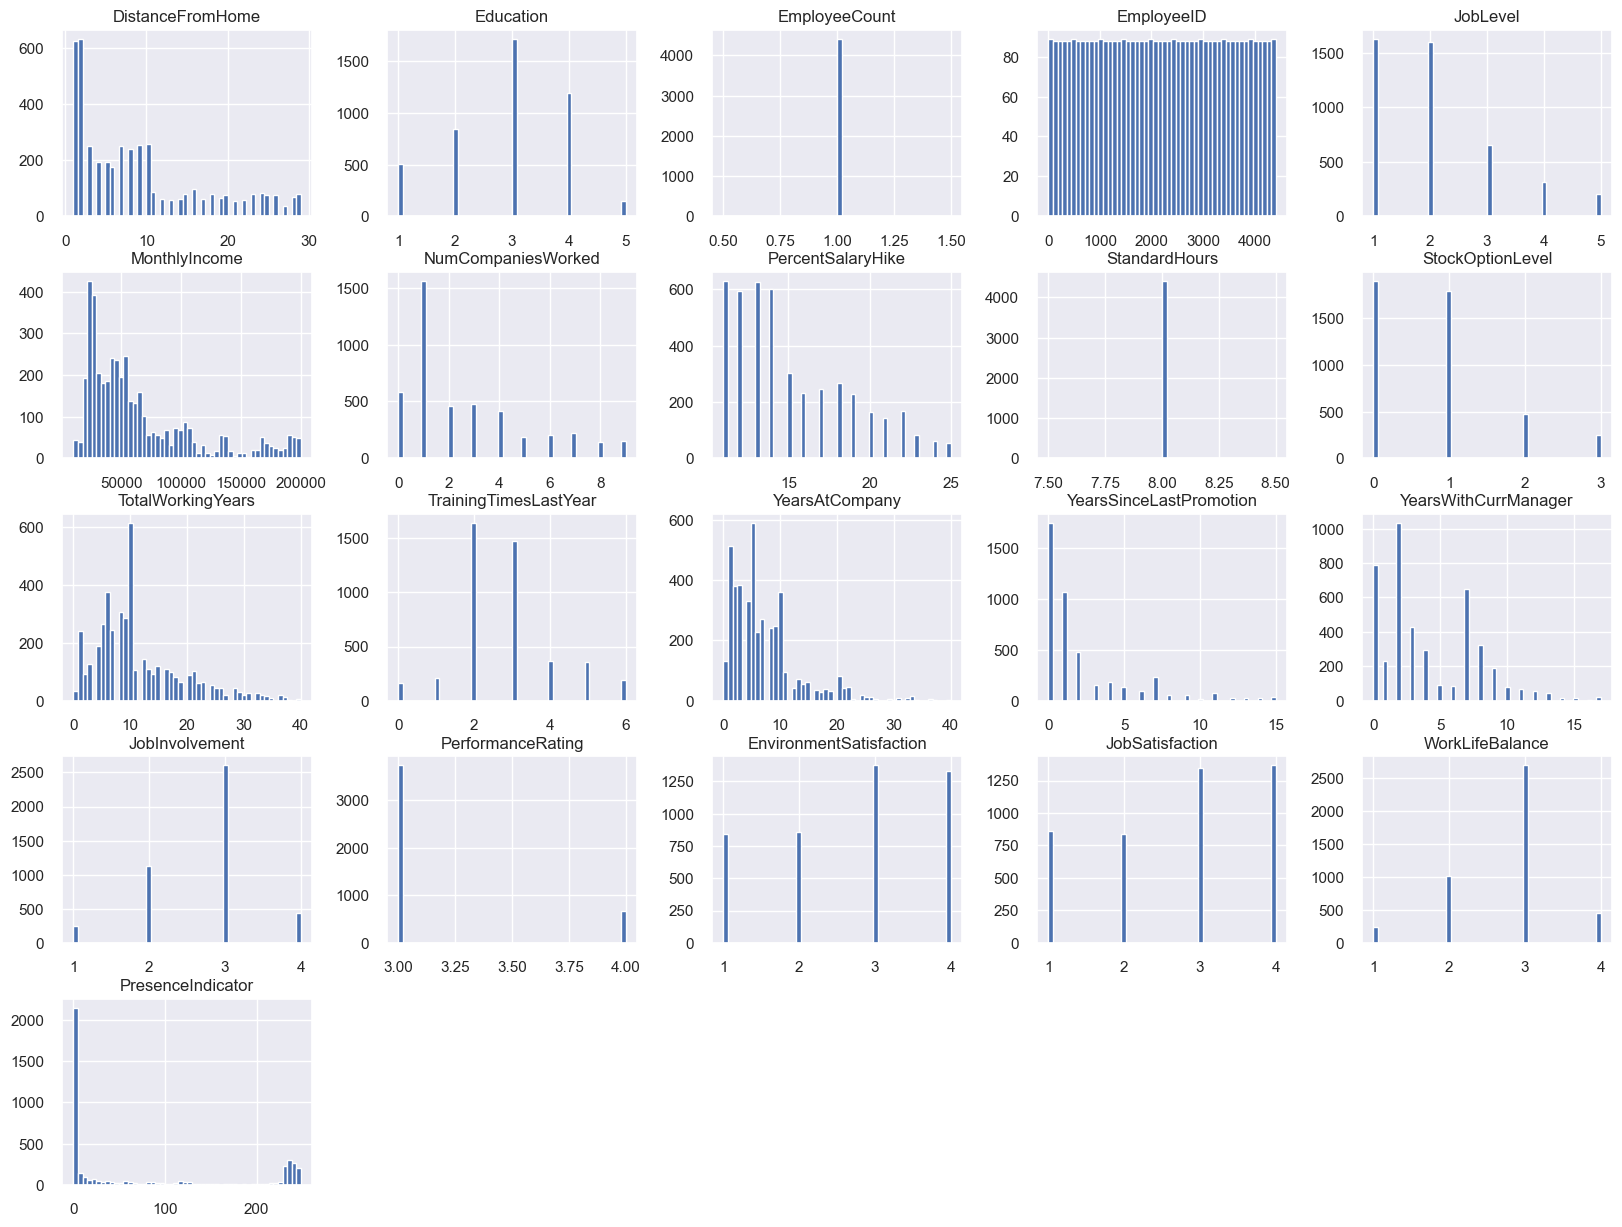

In [71]:
human_for_you_df.hist(bins=50, figsize=(20,15))

Il apparait que certaines variables `EmployeeCount`, `StandardHours` possèdent la même valeur pour tout les employés. Nous allons les supprimer car elles n'apportent pas d'information à notre modèle.

In [72]:
human_for_you_df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeID'], inplace=True)

Nous allons à présent comparer l'impact de nos features sur un potentiel départ des employés de l'entreprise. Pour cela, nous allons utiliser des graphiques de type `countplot` de la bibliothèque `seaborn` pour comparer la distribution de nos features par rapport à notre variable cible `Attrition`.

In [73]:
def make_plot(feature_name):
    plt.figure(figsize = (8,5))
    ax = sns.countplot(x = feature_name, hue = 'Attrition', data = human_for_you_df, palette = 'Set2')
    plt.xlabel(feature_name)
    plt.ylabel('Employee count')
    plt.title('{} vs Attrition'.format(feature_name))
    plt.legend()

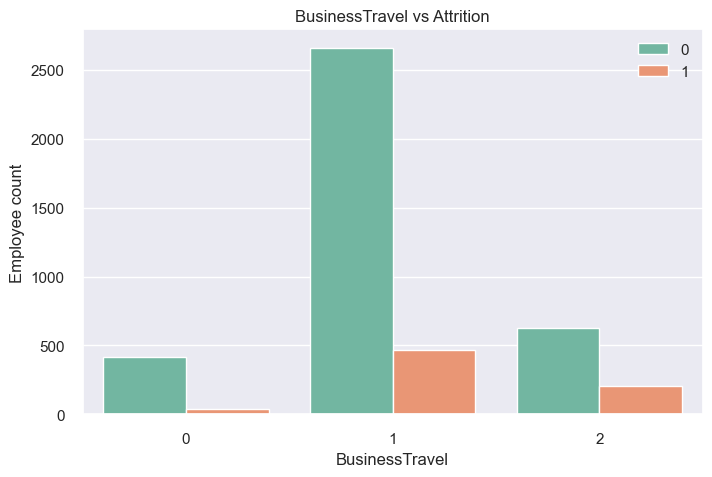

In [147]:
make_plot('BusinessTravel')

In [148]:
make_plot('Department')

ValueError: Could not interpret value `Department` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

In [ ]:
make_plot('Education')

In [ ]:
make_plot('JobLevel')

In [ ]:
make_plot('WorkLifeBalance')

## Encodage des données

L'encodage de données est une étape essentielle dans le processus de préparation des données. Il s'agit de transformer des données brutes, souvent sous forme textuelle ou catégorielle en données numériques que les algorithmes de machine learning peuvent utiliser.

Dans notre contexte, nous avons plusieurs variables catégorielles comme Department, EducationField, JobRole et BusinessTravel.

Pour que les algorithmes de machine learning puissent utiliser ces données, nous devons les transformer en données numériques. Pour cela, nous allons utiliser l'encodage ordinal qui une technique pour encoder les variables catégorielles en données numériques. L'encodage ordinal prend en compte l'ordre des valeurs des variables catégorielles.

En pratique, cela signifie attribuer des nombres entiers aux catégories selon un certain ordre. Par exemple, pour une variable catégorielle avec les valeurs "A", "B" et "C", l'encodage ordinal pourrait attribuer 1 à "A", 2 à "B" et 3 à "C.

L'utilisation de l'encodage ordinal est particulièrement utile lorsque les données catégorielles ont un ordre naturel qui peut influencer le résultat. Par exemple dans les niveau d'éducation, les valeurs "Bac", "Master" et "PhD" ont un ordre naturel qui peut influencer le résultat.

Dans notre cas, pour ces variables il n'y a pas d'ordre naturel ce qui peut influencer le résultat. Toutefois, ces variables possèdent un nombre limité de catégories ce qui rend acceptable l'utilisation de l'encodage ordinal et nous permet de ne pas avoir à utiliser l'encodage one-hot qui peut augmenter le nombre de colonnes de manière significative.

Pour effectuer l'encodage ordinal, nous allons utiliser la classe OrdinalEncoder de la bibliothèque scikit-learn.

In [74]:
encoder = OrdinalEncoder()

human_for_you_df["Department"] = encoder.fit_transform(human_for_you_df[["Department"]])
human_for_you_df["EducationField"] = encoder.fit_transform(human_for_you_df[["EducationField"]])
human_for_you_df["JobRole"] = encoder.fit_transform(human_for_you_df[["JobRole"]])

La variable BusinessTravel est une variable catégorielle avec trois catégories: "Non-Travel", "Travel_Rarely" et "Travel_Frequently" où l'ordre naturel est important. Nous allons donc utiliser l'encodage ordinal pour cette variable en définissant nous même l'ordre des catégories.

In [75]:
human_for_you_df["BusinessTravel"] = human_for_you_df["BusinessTravel"].map({"Non-Travel": 0, "Travel_Rarely": 1, "Travel_Frequently": 2})

Nous allons également encoder notre variable cible `Attrition` en utilisant avec 0 pour "No" et 1 pour "Yes". 

In [76]:
human_for_you_df["Attrition"] = human_for_you_df["Attrition"].map({"Yes": 1, "No": 0})

## Corrélation des données

La corrélation est une mesure statistique qui décrit la force de la relation entre deux variables. Elle peut être utilisée pour déterminer si et comment les variables sont liées entre elles. Nous allons créer une matrice de corrélation pour comprendre la relation entre nos variables et notre variable cible `Attrition` en utilisant la fonction `corr` de pandas. Une fois cette matrice de corrélation établie, nous allons l'afficher sous forme de heatmap pour une meilleure lisibilité. Un heatmap est un outil visuel qui utilise des couleurs pour représenter les valeurs d'une matrice. Il est particulièrement utile pour visualiser les valeurs de la matrice de corrélation. Ici, nous utiliserons la bibliothèque `seaborn` pour afficher notre heatmap.

<AxesSubplot: >

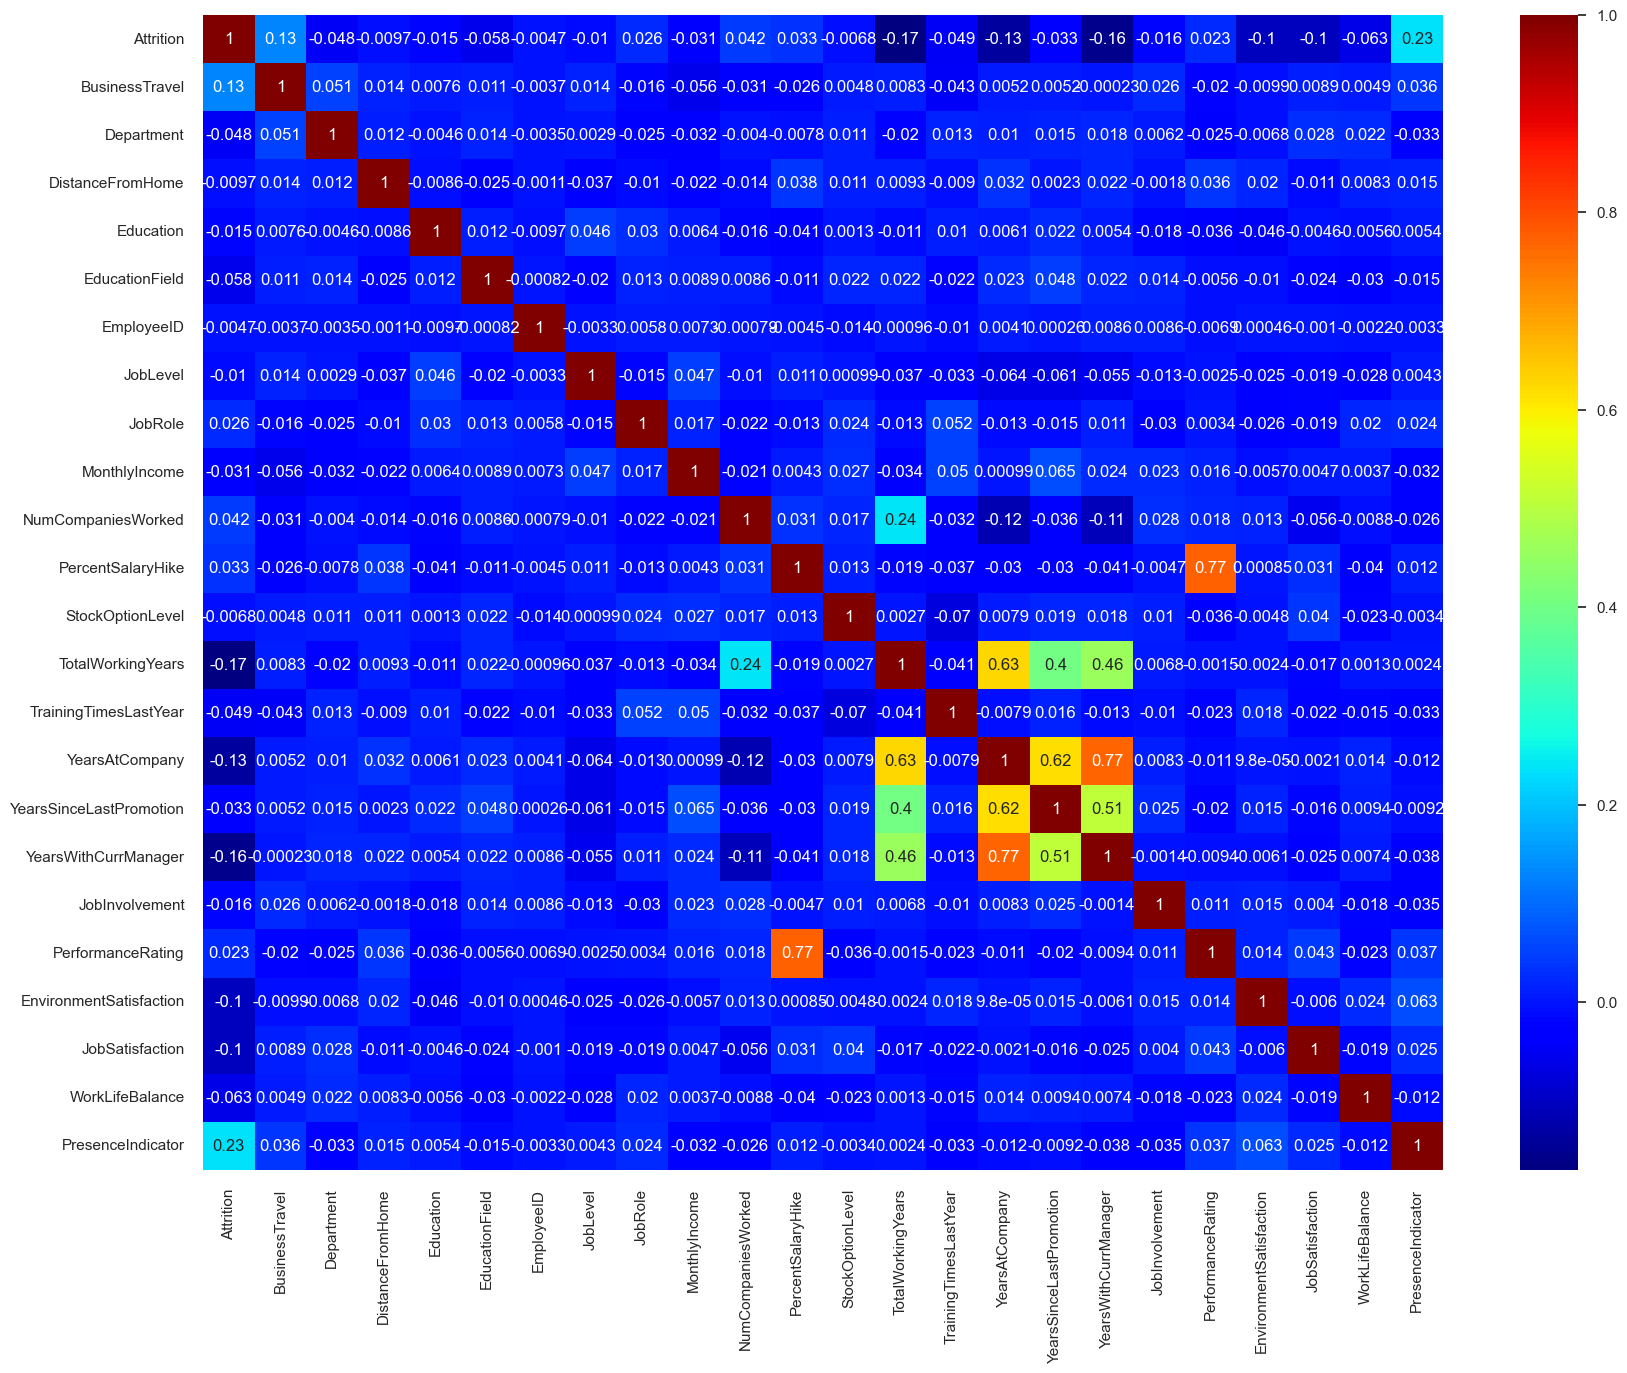

In [77]:
correlation_matrix = human_for_you_df.corr()

plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.get_cmap("jet"))

On remarque très vite que la matrice de corrélation est difficile à lire du fait du grand nombre de corrélation proche de 0. Nous allons donc filtrer les corrélation pour ne garder que les corrélation significatives. Nous définissons une corrélation significative comme une corrélation supérieure à 0.1 et inférieure à -0.1. Nous allons donc remplacer les corrélation inférieures à 0.1 et supérieures à -0.1 par 0 en parcourant notre matrice de corrélation.

<AxesSubplot: >

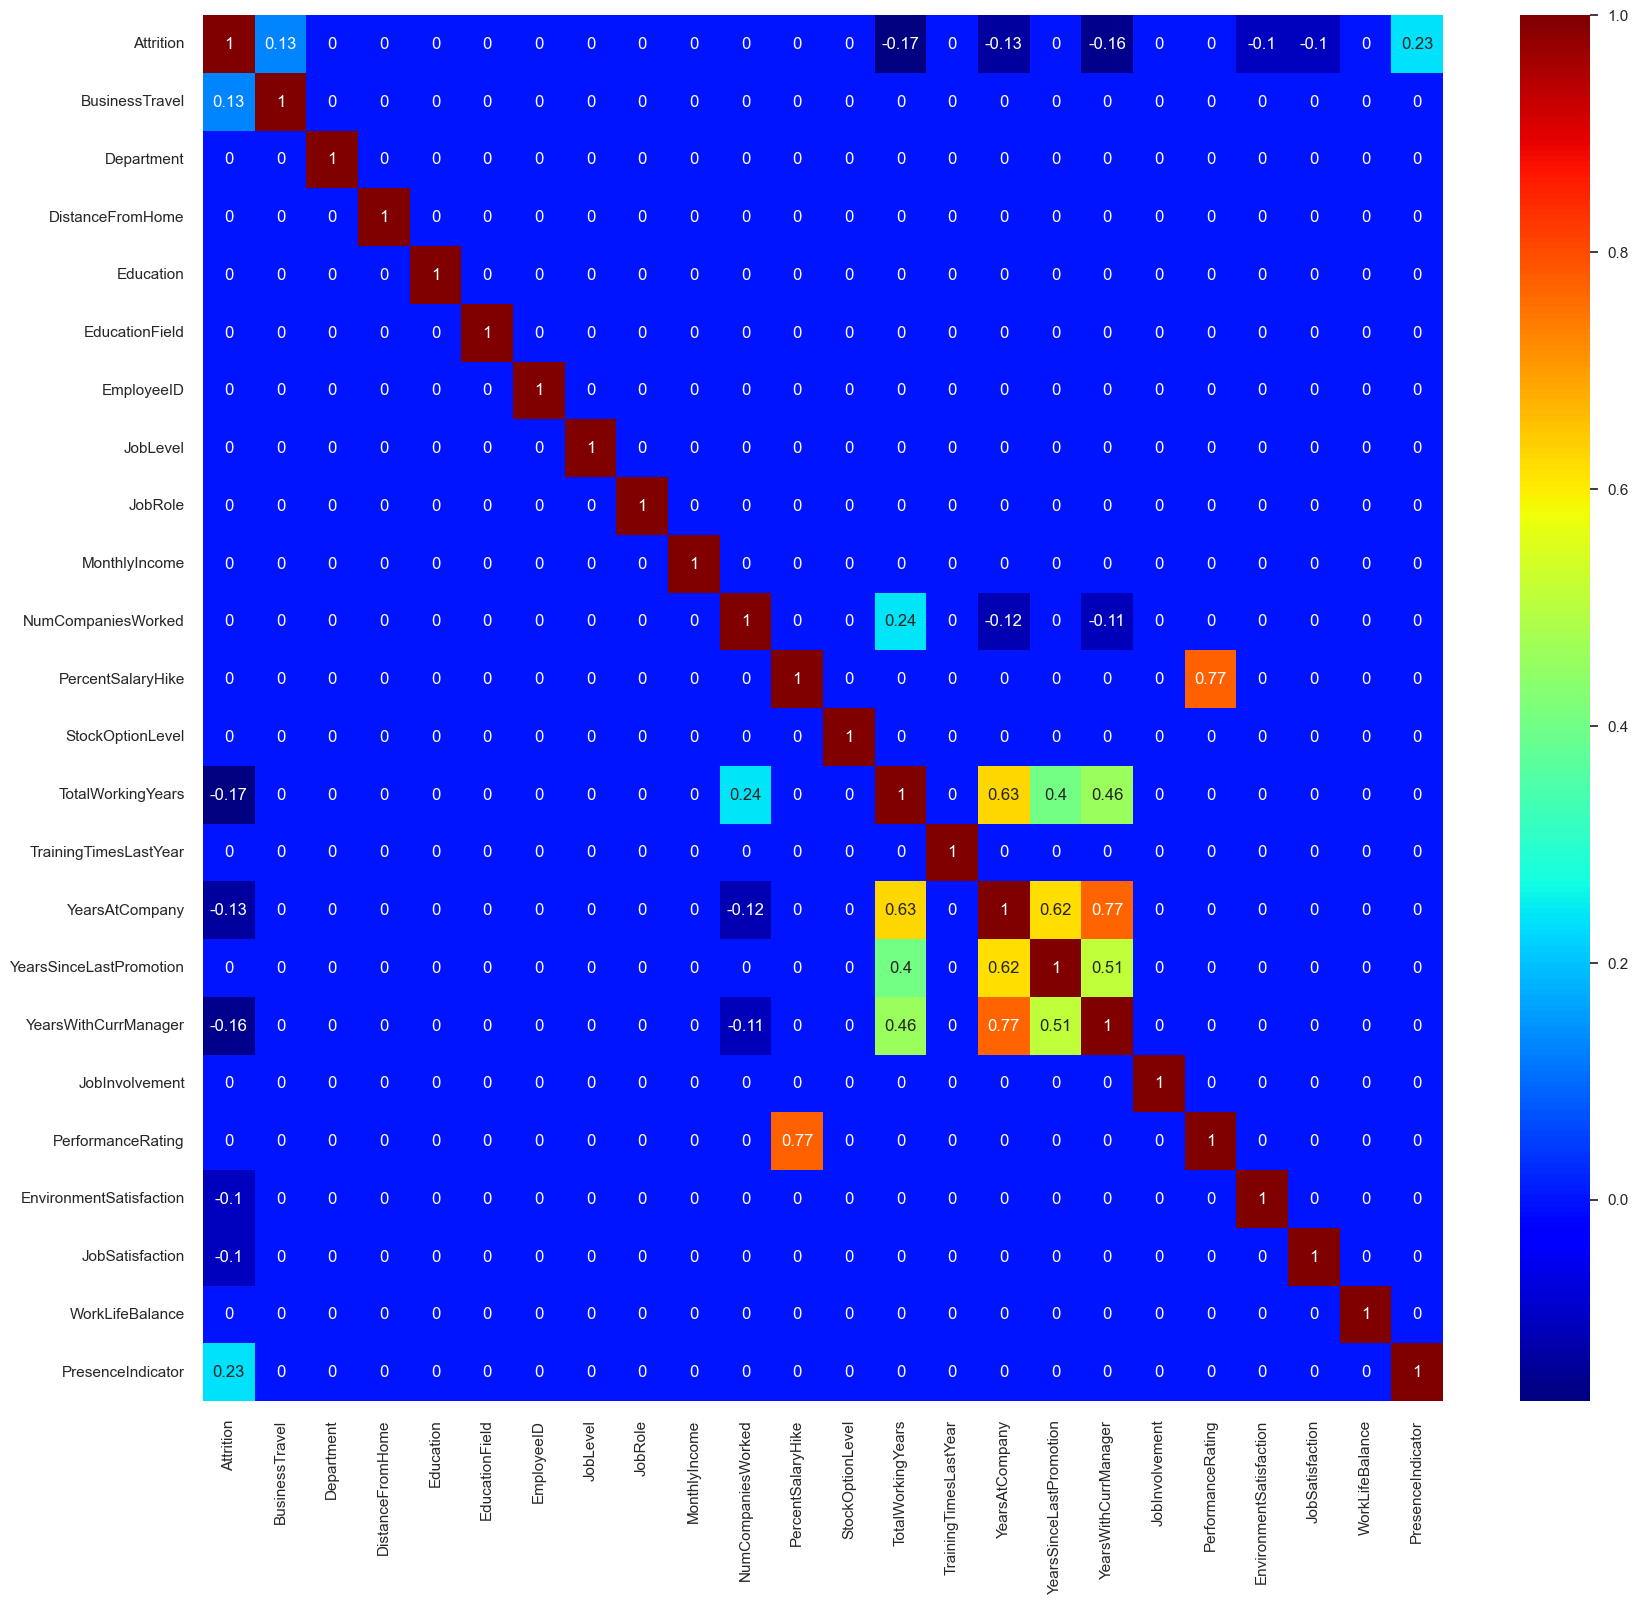

In [78]:
correlation_matrix = correlation_matrix.applymap(lambda x: 0 if abs(x) < 0.1 else x)

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.get_cmap("jet"))

Nous avons maintenant une matrice de corrélation plus lisible. Nous pouvons voir que certaines variables ne sont corrélées à notre variable cible `Attrition`. Nous allons donc les suppimer pour ne garder que les variables significatives.

### Variable supprimée 

- Department
- EducationField
- JobRole
- DistanceFromHome
- Education
- JobLevel
- MonthlyIncome
- NumCompaniesWorked
- PercentSalaryHike
- StockOptionLevel
- TrainingTimesLastYear
- YearsSinceLastPromotion
- JobInvolvement
- PerformanceRating
- WorkLifeBalance

In [79]:
human_for_you_df.drop("Department", axis=1, inplace=True)
human_for_you_df.drop("EducationField", axis=1, inplace=True)
human_for_you_df.drop("JobRole", axis=1, inplace=True)
human_for_you_df.drop("DistanceFromHome", axis=1, inplace=True)
human_for_you_df.drop("Education", axis=1, inplace=True)
human_for_you_df.drop("JobLevel", axis=1, inplace=True)
human_for_you_df.drop("MonthlyIncome", axis=1, inplace=True)
human_for_you_df.drop("NumCompaniesWorked", axis=1, inplace=True)
human_for_you_df.drop("PercentSalaryHike", axis=1, inplace=True)
human_for_you_df.drop("StockOptionLevel", axis=1, inplace=True)
human_for_you_df.drop("TrainingTimesLastYear", axis=1, inplace=True)
human_for_you_df.drop("YearsSinceLastPromotion", axis=1, inplace=True)
human_for_you_df.drop("JobInvolvement", axis=1, inplace=True)
human_for_you_df.drop("PerformanceRating", axis=1, inplace=True)
human_for_you_df.drop("WorkLifeBalance", axis=1, inplace=True)

Nous avons maintenant les données qui seront utilisées pour notre modèle de machine learning. Nos données sont au nombre de 7 variables et 1 variable cible.

In [82]:
human_for_you_df.head()

,Attrition,BusinessTravel,TotalWorkingYears,YearsAtCompany,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,PresenceIndicator
0,0,1,1.0,1,0,3.0,4.0,0
1,1,2,6.0,5,4,3.0,2.0,42
2,0,2,5.0,5,3,2.0,2.0,0
3,0,0,13.0,8,5,4.0,4.0,0
4,0,1,9.0,6,4,4.0,1.0,115


# Choix des métriques de performance 

Afin de mesurer la performance de nos modèles pour savoir quels seront les meilleurs modèles, il est important de définir en amont des métriques de performance pour effectuer ce choix. Pour ce faire il existe plusieurs métriques de performance pour les problèmes de classification binaire.

### Matrice de confusion

La matrice de confusion est une métrique qui permet de mesurer la performance d'un modèle de classification. Elle est particulièrement utile pour évaluer la performance d'un modèle sur des problèmes de classification binaire. Elle permet de visualiser les prédictions d'un modèle par rapport aux vraies valeurs. Elle est composée de quatre éléments :

- **True Positives (TP)** : Les vrais positifs sont les cas où le modèle prédit correctement la classe positive.
- **True Negatives (TN)** : Les vrais négatifs sont les cas où le modèle prédit correctement la classe négative.
- **False Positives (FP)** : Les faux positifs sont les cas où le modèle prédit à tort la classe positive.
- **False Negatives (FN)** : Les faux négatifs sont les cas où le modèle prédit à tort la classe négative.



|     Prédit \ Réel      |      Positif (P)      |      Négatif (N)      |
|:----------------------:|:---------------------:|:---------------------:|
|    **Positif (P)**     | PV (True Positive)    | FP (False Positive)   |
|    **Négatif (N)**     | FN (False Negative)   | NV (True Negative)    |

### Accuracy

L'accuracy est la métrique la plus simple et la plus utilisée pour mesurer la performance d'un modèle. Elle représente le nombre de prédictions correctes (à la fois positives et négatives) par rapport au nombre total de prédictions. Cependant, cette métrique n'est pas toujours la meilleure pour mesurer la performance d'un modèle. En effet, dans le cas où les classes ne sont pas équilibrées, l'accuracy peut être trompeuse. Par exemple, si 90% des données appartiennent à la classe 1 et 10% à la classe 0, un modèle qui prédit toujours la classe 1 aura une accuracy de 90%.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

## Precision

La precision est une métrique qui mesure la proportion de vrais positifs parmi les prédictions positives. Elle est utile lorsque le coût des faux positifs est élevé. Par exemple, dans le cas d'un modèle qui prédit si un email est un spam ou non, il est préférable d'avoir un faible taux de faux positifs (emails légitimes classés comme spam) même si cela signifie que certains spams seront classés comme légitimes.

$$
\text{Précision} = \frac{TP}{TP + FP}
$$

## Recall 

Le recall (ou rappel) est une métrique qui mesure la proportion de vrais positifs parmi les vrais positifs et les faux négatifs. Elle est utile lorsque le coût des faux négatifs est élevé. Par exemple, dans le cas d'un modèle qui prédit si un patient a une maladie ou non, il est préférable d'avoir un faible taux de faux négatifs (patients malades classés comme sains) même si cela signifie que certains patients sains seront classés comme malades.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

## F1 Score

Le F1 score est la moyenne harmonique de la precision et du recall. Il est utile lorsque les classes sont déséquilibrées. En effet, dans ce cas, l'accuracy n'est pas une bonne métrique de performance. Par exemple, si 90% des données appartiennent à la classe 1 et 10% à la classe 0, un modèle qui prédit toujours la classe 1 aura une accuracy de 90%. Cependant, le F1 score de ce modèle sera de 0. 

$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

## AUC-ROC 

L'AUC-ROC (Area Under the Receiver Operating Characteristic Curve) est la mesure de la capacité d'un modèle à distinguer entre les classes. ROC est une courbe de probabilité qui trace le taux de vrais positifs contre le taux de faux positifs à différents seuils de classification. 

Un modèle qui fait des prédictions parfaites aurait une AUC de 1, tandis qu'un modèle qui fait des prédictions aléatoires aurait une AUC de 0.5.

L'AUC-ROC est particulièrement utile lorsque les classes sont déséquilibrées. Elle est insensible au déséquilibre des classes et se concentre sur la capacité du modèle à distinguer entre les classes. Cependant, si le coût des faux positifs est très élevé, il peut être trompeur.

## AUC PR

L'AUC-PR est similaire à l'AUC-ROC mais se concentre sur la relation entre la précision (proportion de vrai positifs parmis les prédiction positives) et le recall (proportion de vrais positifs parmis les vrais cas positifs). 

Dans un contexte où les positifs (comme les spams dans un exemple de filtrage) sont rares, l'AUC-PR donne une meilleure indication de la performance du modèle. 

L'AUC-PR est préférable lorsque le déséquilibre des classe est un problème et que l'on s'intéresse davantage à la performance du modèle sur la classe minoritaire. Il est plus informatif que l'AUC-ROC dans les cas où les positifs sont beaucoup moins fréquents que les négatifs.

## Choix appliqué au contexte 

Pour le problème de l'attrition des employés, qui est un problème de classification binaire (les employés quittent ou ne quittent pas l'entreprise) 

Il est important de prendre en compte le coût relatif des erreurs (faux positifs vs faux négatifs) et la distribution de la classe (équilibrée ou déséquilibrée).

* Si le *coût d'un faux négatif* (ne pas identifier un employé qui est susceptible de quitter) est élevée car cela pourrait perturber les opérations de l'entreprise, entaîner la perte de talent clés ou nuire à la plannification des ressources, alors il est préférable de privilégier *le recall*.

* Si le coût d'un faux positif (croire à tort qu'un employé va partir) est élevée, ce qui peut conduire à un problème éthique et conduire à des dépenses inutiles en interventions de rétention ou à une ambiance de méfiance, alors il est préférable de privilégier la précision. 

Dans le contexte de notre problème, ces deux types d'erreurs sont importants, le F1-Score peut être un bon choix car il équilibre la précision et le recall. Cependant nos données étant déséquilibrées, les mesures telles que la précision, le recall et le F1-Score peuvent ne pas refléter fidèlement la performance de notre modèle.

Dans ce cas L'AUC-ROC ou l'AUC-PR pourraient être plus appropriées. L'AUC-ROC est moins sensible aux déséquilibres de classe, mais si la classe positive (les employés qui quittent est beaucoup plus petite, l'AUC-PR peut être préférable car elle se concentre sur la classe minoritaire. 

Les autres métriques sont évidemment utiles pour évaluer la performance des modèles, mais prendrons en priorité l'AUC-PR et le F1-Score pour évaluer la performance de nos modèles. Nous utiliserons également la matrice de confusion pour évaluer la performance de nos modèles.

# Choix du modèle 

Afin de choisir le modèle le plus adapté à notre problème de classification, nous allons comparer les performances de plusieurs modèles de classification. Pour réaliser cela, nous allons utiliser la bibliothèque `pycaret` qui permet de comparer les performances de plusieurs modèles de classification. Cette bibliothèque va lancer un processus d'entraînement et de test sur plusieurs modèles de classification et nous donnera les performances de chacun de ces modèles.

Grâce à cette bibliothèque, nous pourrons comparer les performances de plusieurs modèles et ainsi nous pourrons choisir les modèles les plus performants pour notre problème de classification. Cette étape n'est qu'une étape de discrimination des modèles pour ce concentrer sur les plus performants, nous pourrons ensuite affiner notre choix en optimisant les hyperparamètres des modèles les plus performants.

La métrique de l'AUC-PR n'étant pas nativement disponible dans la bibliothèque `pycaret`. Toutefois il est possible de créer une métrique personnalisée pour l'AUC-PR. 

Pour cela, nous allons utiliser la fonction precision_recall_curve de la bibliothèque `sklearn` pour calculer la précision et le recall pour chaque seuil de classification. Nous allons ensuite utiliser la fonction auc de la bibliothèque `sklearn` pour calculer l'aire sous la courbe de précision-rappel. Nous allons ensuite utiliser la fonction add_metric de la bibliothèque `pycaret` pour ajouter cette métrique personnalisée à notre processus de comparaison de modèles.

In [107]:
def auc_pr_score(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

In [84]:
clf = setup(data=human_for_you_df, target='Attrition')
add_metric('AUC-PR', 'AUC-PR', auc_pr_score, greater_is_better=True)
best__models = compare_models(sort='AUC-PR')

results = pull()

results

,Description,Value
0,Session id,4441
1,Target,Attrition
2,Target type,Binary
3,Original data shape,"(4410, 8)"
4,Transformed data shape,"(4410, 8)"
5,Transformed train set shape,"(3087, 8)"
6,Transformed test set shape,"(1323, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:24:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUC-PR,TT (Sec)
et,Extra Trees Classifier,0.9686,0.9793,0.8574,0.9435,0.8973,0.8789,0.8810,0.9120,0.0310
rf,Random Forest Classifier,0.9546,0.9689,0.7912,0.9184,0.8488,0.8224,0.8263,0.8717,0.0370
dt,Decision Tree Classifier,0.9336,0.8875,0.7952,0.7964,0.7944,0.7548,0.7558,0.8123,0.0060
lightgbm,Light Gradient Boosting Machine,0.9158,0.9337,0.6067,0.8289,0.6994,0.6518,0.6633,0.7496,0.1190
gbc,Gradient Boosting Classifier,0.8730,0.8446,0.3433,0.7258,0.4652,0.4035,0.4405,0.5875,0.0270
dummy,Dummy Classifier,0.8387,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5807,0.0050
ada,Ada Boost Classifier,0.8614,0.8050,0.2729,0.6738,0.3877,0.3252,0.3680,0.5320,0.0180
nb,Naive Bayes,0.8575,0.7608,0.3313,0.6077,0.4283,0.3549,0.3765,0.5234,0.0050
qda,Quadratic Discriminant Analysis,0.8558,0.7649,0.3233,0.6017,0.4191,0.3454,0.3678,0.5171,0.0050
knn,K Neighbors Classifier,0.8445,0.8255,0.3312,0.5266,0.4052,0.3216,0.3336,0.4829,0.0100


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,AUC-PR,TT (Sec)
et,Extra Trees Classifier,0.9686,0.9793,0.8574,0.9435,0.8973,0.8789,0.8810,0.9120,0.031
rf,Random Forest Classifier,0.9546,0.9689,0.7912,0.9184,0.8488,0.8224,0.8263,0.8717,0.037
dt,Decision Tree Classifier,0.9336,0.8875,0.7952,0.7964,0.7944,0.7548,0.7558,0.8123,0.006
lightgbm,Light Gradient Boosting Machine,0.9158,0.9337,0.6067,0.8289,0.6994,0.6518,0.6633,0.7496,0.119
gbc,Gradient Boosting Classifier,0.8730,0.8446,0.3433,0.7258,0.4652,0.4035,0.4405,0.5875,0.027
dummy,Dummy Classifier,0.8387,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5807,0.005
ada,Ada Boost Classifier,0.8614,0.8050,0.2729,0.6738,0.3877,0.3252,0.3680,0.5320,0.018
nb,Naive Bayes,0.8575,0.7608,0.3313,0.6077,0.4283,0.3549,0.3765,0.5234,0.005
qda,Quadratic Discriminant Analysis,0.8558,0.7649,0.3233,0.6017,0.4191,0.3454,0.3678,0.5171,0.005
knn,K Neighbors Classifier,0.8445,0.8255,0.3312,0.5266,0.4052,0.3216,0.3336,0.4829,0.010


Nous avons maintenant les performances de plusieurs modèles de classification. On remarque que le modèle `Extra Trees Classifier` est le modèle le plus performant avec une AUC-PR de 0.91, suivi du modèle `Random Forest Classifier` avec une AUC-PR de 0.87. Ces modèles possèdent également un F1-Score élevé, ce qui est un bon indicateur de performance pour notre problème de classification. Nous allons donc choisir ces deux modèles pour la suite de notre analyse afin de limiter le nombre de modèles à optimiser.

Nous allons dans un premier temps expliquer le fonctionnement de ces modèles, puis nous allons les implémenter, les évaluer sur nos données puis les optimiser pour obtenir les meilleurs performances possibles et enfin choisir le modèle le plus performant pour notre problème de classification.

## Random Forest Classifier

Le `RandomForestClassifier` est un algorithme d'apprentissage automatique qui utilise une combinaison de plusieurs arbres de décision pour améliorer la précision et réduire le risque de surajustement. Il fonctionne en entraînant chaque arbre sur un échantillon aléatoire du jeu de données (bootstrap) et en introduisant de la randomisation dans la sélection des caractéristiques pour les divisions. La prédiction finale est déterminée par un vote majoritaire parmi tous les arbres. Cette méthode d'ensemble rend le modèle robuste et précis, capable de gérer des données complexes, tout en fournissant des insights sur l'importance des caractéristiques.

## Fonctionnement

### Construction des arbres

- **Bootstrap Aggregating (Bagging)** : Pour chaque arbre, un échantillon aléatoire des données d'entraînement est sélectionné avec remplacement. Cela permet de réduire la variance et d'éviter le surajustement.
- **Sélection aléatoire des caractéristiques** : Lors de la construction de chaque nœud de l'arbre, un sous-ensemble aléatoire des caractéristiques est choisi pour la division, ce qui augmente la diversité entre les arbres et contribue à une meilleure généralisation.

### Prédiction

- **Vote majoritaire** : Pour la classification, la prédiction finale est déterminée par un vote majoritaire des prédictions des différents arbres.
- **Moyenne** : Pour la régression, la prédiction est la moyenne des prédictions des arbres individuels.

### Avantages

- **Robustesse** : En combinant les prédictions de nombreux arbres, le modèle est moins sensible au surajustement.
- **Flexibilité** : Peut être utilisé pour les tâches de classification et de régression.
- **Importance des caractéristiques** : Fournit des mesures d'importance des caractéristiques, ce qui est utile pour la sélection de caractéristiques.

## Paramètres importants

- `n_estimators` : Le nombre d'arbres dans la forêt. Un nombre plus élevé augmente la précision mais aussi le temps de calcul.
- `max_features` : Le nombre de caractéristiques à considérer lors de la recherche de la meilleure scission. Des valeurs plus faibles réduisent le risque de surajustement.
- `max_depth` : La profondeur maximale des arbres. Limiter la profondeur peut aider à prévenir le surajustement.
- `min_samples_split` : Le nombre minimal d'échantillons requis pour diviser un nœud.
- `min_samples_leaf` : Le nombre minimal d'échantillons requis dans un nœud feuille.

## Extra Trees Classifier

Le `ExtraTreesClassifier` est un algorithme d'ensemble basé sur des arbres de décision qui améliore la classification en introduisant une randomisation supplémentaire dans la construction des arbres. Il construit de nombreux arbres en utilisant l'ensemble des données d'entraînement pour chaque arbre et choisit les points de division des caractéristiques de manière aléatoire, contrairement à la recherche du meilleur seuil comme le fait le `RandomForestClassifier`. La prédiction finale est obtenue en moyennant les prédictions de tous les arbres. Cette méthode augmente la diversité des arbres et réduit le risque de surajustement, rendant le modèle particulièrement efficace pour les ensembles de données complexes avec un calcul relativement rapide et une robustesse accrue face aux variations des données.

## Fonctionnement

### Création des Arbres

- **Extrême Randomisation** : Contrairement aux forêts aléatoires qui recherchent le meilleur seuil pour chaque caractéristique lors de la division d'un nœud, `ExtraTreesClassifier` choisit des seuils de manière totalement aléatoire pour chaque caractéristique et sélectionne le meilleur de ces seuils comme règle de division. Cela augmente la diversité parmi les arbres de la forêt.
- **Utilisation de l'ensemble de données entier** : Pour chaque arbre, l'algorithme utilise l'ensemble du jeu de données d'apprentissage plutôt que d'utiliser un sous-ensemble bootstrap comme dans les forêts aléatoires.

### Avantages

- **Réduction de la variance** : En utilisant de nombreux arbres et en moyennant leurs prédictions, l'algorithme réduit le risque de surajustement sur le jeu de données d'entraînement.
- **Efficacité** : La sélection aléatoire des seuils pour les caractéristiques réduit le temps de calcul nécessaire pour entraîner chaque arbre.
- **Robustesse** : La diversité accrue parmi les arbres rend le modèle plus robuste face aux variations des données d'entrée.

## Paramètres importants

- `n_estimators` : Nombre d'arbres dans la forêt. Plus il y a d'arbres, plus le modèle est robuste, mais cela augmente le coût computationnel.
- `max_features` : Le nombre de caractéristiques à considérer lors de la recherche de la meilleure division. Joue un rôle crucial dans la diversification des arbres.
- `max_depth` : La profondeur maximale des arbres. Une profondeur illimitée peut conduire à un surajustement.
- `min_samples_split` : Le nombre minimum d'échantillons requis pour diviser un nœud interne.
- `min_samples_leaf` : Le nombre minimum d'échantillons requis pour être à un nœud feuille.

## Différences Principales : RandomForest vs ExtraTrees

### Sélection des Caractéristiques pour les Divisions
- **RandomForest** : Recherche le meilleur seuil parmi un sous-ensemble aléatoire des caractéristiques.
- **ExtraTrees** : Choisit un seuil aléatoirement pour chaque caractéristique et utilise le meilleur de ces seuils.

### Construction de l'Arbre
- **RandomForest** : Utilise des échantillons bootstrap de l'ensemble de données pour chaque arbre.
- **ExtraTrees** : Utilise l'ensemble de données complet pour chaque arbre, augmentant la randomisation.

### Vitesse et Complexité
- **RandomForest** : Plus lent à entraîner en raison de la recherche du meilleur seuil pour les divisions.
- **ExtraTrees** : Plus rapide à entraîner grâce à la sélection aléatoire des seuils, réduisant le temps de calcul.

### Variance et Biais
- **RandomForest** : Vise à réduire la variance sans augmenter significativement le biais, grâce à une sélection minutieuse des seuils.
- **ExtraTrees** : Peut augmenter le biais mais réduit généralement la variance, offrant une robustesse accrue au surajustement.

Ces différences influencent le choix de l'algorithme en fonction des spécificités du problème, de la taille et de la nature des données, ainsi que des contraintes de temps de calcul.


# Standardisation des données

La standardisation des données est une étape importante dans le processus de préparation des données. Elle consiste à mettre à l'échelle les données pour qu'elles aient une moyenne nulle et un écart type unitaire. Cela permet de rendre les données comparables et de faciliter l'entraînement des modèles de machine learning. Bien que nos données soient dans un ordre de grandeur similaire, la standardisation peut améliorer la convergence des algorithmes d'optimisation et la performance des modèles. Nous allons donc standardiser nos données en utilisant la classe `StandardScaler` de la bibliothèque `scikit-learn`.

In [88]:
scaler = StandardScaler()

X = human_for_you_df.drop(columns='Attrition')
y = human_for_you_df['Attrition']

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Définition des jeux de test, d'entraînement et de validation

Avant d'entraîner nos modèles, nous allons diviser nos données en trois jeux de données distincts : un jeu de données d'entraînement, un jeu de données de validation et un jeu de données de test. Nous allons utiliser le jeu de données d'entraînement pour entraîner nos modèles, le jeu de données de validation pour évaluer la performance de nos modèles et ajuster les hyperparamètres, et le jeu de données de test pour évaluer la performance finale de nos modèles. 

Grâce à la fonction `train_test_split` de la bibliothèque `scikit-learn`, nous allons diviser nos données en un jeu de données d'entraînement et un jeu de données de test. Nous allons ensuite diviser le jeu de données d'entraînement en un jeu de données d'entraînement et un jeu de données de validation. Nous allons utiliser la fonction `StratifiedShuffleSplit` de la bibliothèque `scikit-learn` pour diviser nos données de manière stratifiée afin de conserver la distribution des classes dans nos jeux de données.

Après une recherche approfondie sur les meilleures pratiques pour diviser les données, nous avons décidé de diviser nos données de la manière suivante :
- 70% des données pour le jeu de données d'entraînement
- 15% des données pour le jeu de données de validation
- 15% des données pour le jeu de données de test

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Implémentation du Random Forest Classifier

Après recherche sur les meilleures pratiques pour l'implémentation du `RandomForestClassifier`, nous avons décidé d'implémenter le modèle avec les paramètres suivants :
- `n_estimators` : 100
- `max_features` : 'auto'
- `min_samples_split` : 2
- `min_samples_leaf` : 1
- `bootstrap` : True

Nous allons utiliser la classe `RandomForestClassifier` de la bibliothèque `scikit-learn` pour implémenter notre modèle. Nous allons ensuite entraîner notre modèle sur le jeu de données d'entraînement, évaluer sa performance sur le jeu de données de test et afficher les résultats.

In [90]:
random_classifier_model = RandomForestClassifier(n_estimators=100, max_features='auto', min_samples_split=2, min_samples_leaf=1, bootstrap=True)
random_classifier_model.fit(X_train, y_train)

y_pred_random_forest = random_classifier_model.predict(X_test)

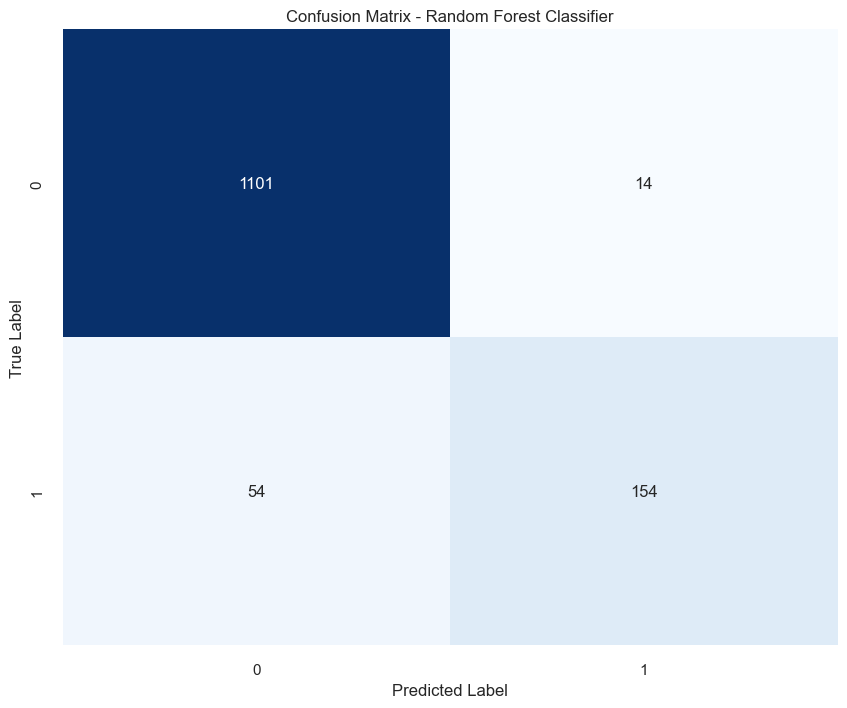

In [92]:
random_forest_confusion_matrix = confusion_matrix(y_test, y_pred_random_forest)

plt.figure(figsize=(10, 8))
sns.heatmap(random_forest_confusion_matrix, annot=True, cmap=plt.get_cmap("Blues"), cbar=False, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

## Analyse de la Matrice de Confusion

- La grande majorité des employés restant dans l'entreprise sont correctement identifiés (1101 sur 1115), ce qui montre une excellente capacité du modèle à prédire les employés restant.
- Le modèle a une bonne capacité à identifier les employés quittant l'entreprise (154 sur 208), mais manque une portion des cas réels de cette catégorie comme le montre le nombre de faux négatifs (54).
- Le nombre de faux positifs est relativement faible (14), indiquant que le modèle ne tend pas à sur-identifier les employés quittant l'entreprise.
- Le nombre de faux négatif (54) souligne un enjeu important : une portion des employés quittant l'entreprise ne sont pas correctement identifiés par le modèle.

En résumé notre modèle est très efficace pour identifier les employés restant dans l'entreprise, mais montre une capacité légèrement réduite à identifier tous les employés quittant l'entreprise. Pour améliorer la capacité du modèle à identifier les employés quittant l'entreprise, nous allons évaluer la performance du modèle sur d'autres métriques de performance.

In [93]:
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1115
           1       0.92      0.74      0.82       208

    accuracy                           0.95      1323
   macro avg       0.93      0.86      0.89      1323
weighted avg       0.95      0.95      0.95      1323


## Analyse des Résultats du Modèle Random Forest

Le modèle Random Forest a été évalué sur sa capacité à classifier les employés en deux catégories, ceux restant dans l'entreprise (`0`) et ceux la quittant (`1`) :

### Précision
- **Catégorie 0 (Restent) :** Précision de 0.95, indiquant une haute fiabilité dans les prédictions pour les employés restant.
- **Catégorie 1 (Quittent) :** Précision de 0.92, montrant une bonne fiabilité pour les prédictions des départs.

### Rappel
- **Catégorie 0 :** Rappel exceptionnellement élevé de 0.99, signifiant que presque tous les cas réels sont correctement identifiés.
- **Catégorie 1 :** Rappel de 0.74, révélant que le modèle a manqué une portion des cas réels de cette catégorie.

### F1-Score
- **Catégorie 0 :** F1-Score de 0.97, démontrant un excellent équilibre entre précision et rappel.
- **Catégorie 1 :** F1-Score de 0.82, bon mais avec une marge d'amélioration due au rappel plus faible.

### Performance Globale
- **Précision globale :** 0.95, avec 95% des prédictions totales correctes.
- **Moyenne Macro :** Précision de 0.93 et F1-Score de 0.89, indiquant de bonnes performances générales.
- **Moyenne Pondérée :** Tant la précision que le F1-Score sont de 0.95, prenant en compte la distribution inégale des classes.

### Conclusion
Le modèle excelle dans la prédiction des employés restant, mais montre une capacité légèrement réduite à identifier tous les employés quittant l'entreprise. Cela est confirmé par le rappel plus faible pour la catégorie `1`. Pour améliorer la capacité du modèle à identifier les employés quittant l'entreprise, nous allons évaluer la performance du modèle sur d'autres métriques de performance.


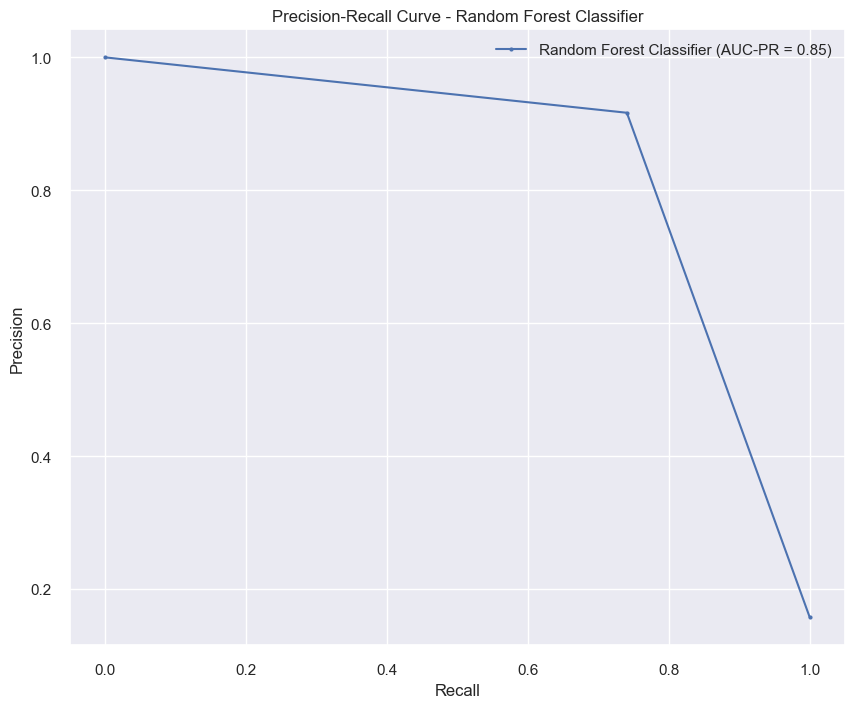

In [108]:
auc_pr_score_random_forest = auc_pr_score(y_test, y_pred_random_forest)
precision, recall, _ = precision_recall_curve(y_test, y_pred_random_forest)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.', label='Random Forest Classifier (AUC-PR = %0.2f)' % auc_pr_score_random_forest)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Classifier')
plt.legend()
plt.show()

## Analyse de la Courbe Précision-Rappel

Nous obtenons un AUC-PR de 0.85 pour le modèle Random Forest Classifier. La courbe précision-rappel montre une relation entre la précision et le rappel pour différents seuils de classification. Elle est particulièrement utile pour évaluer la performance d'un modèle sur des problèmes de classification binaire lorsque les classes sont déséquilibrées. Cette AUC-PR, a une excellente capacité à discriminer entre les classes positives (employés quittant l'entreprise) et négatives (employés restant dans l'entreprise). 

## Implémentation de l'Extra Trees Classifier

Après recherche sur les meilleures pratiques pour l'implémentation de l'`ExtraTreesClassifier`, nous avons décidé d'implémenter le modèle avec les paramètres suivants :
- `n_estimators` : 100
- `max_features` : 'auto'
- `min_samples_split` : 2
- `min_samples_leaf` : 1
- `bootstrap` : True

Nous allons utiliser la classe `ExtraTreesClassifier` de la bibliothèque `scikit-learn` pour implémenter notre modèle. Nous allons ensuite entraîner notre modèle sur le jeu de données d'entraînement, évaluer sa performance sur le jeu de données de test et afficher les résultats.

In [109]:
extra_trees_classifier_model = ExtraTreesClassifier(n_estimators=100, max_features='auto', min_samples_split=2, min_samples_leaf=1, bootstrap=True)
extra_trees_classifier_model.fit(X_train, y_train)

y_pred_extra_trees = extra_trees_classifier_model.predict(X_test)

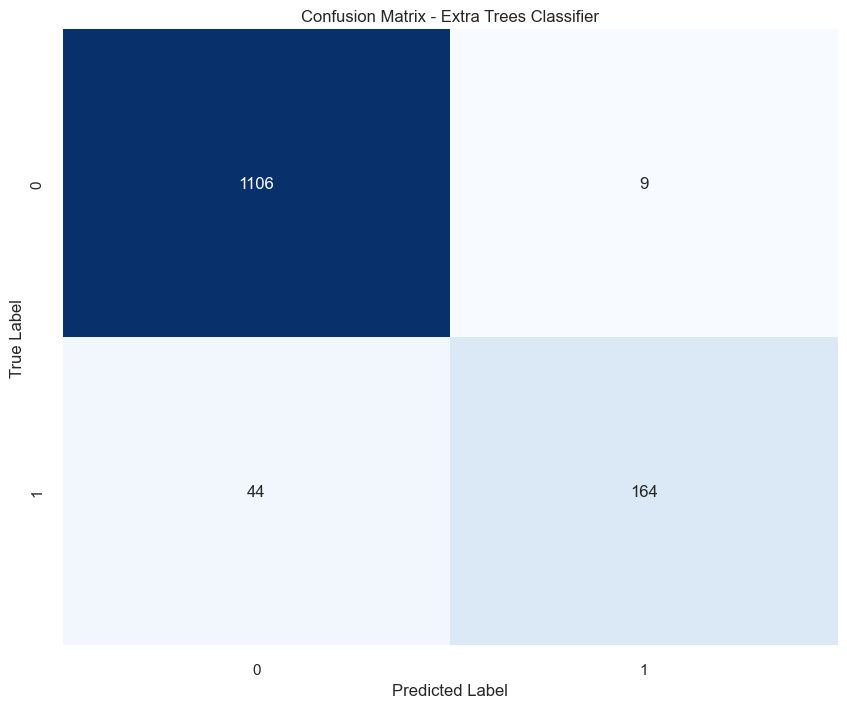

In [110]:
extra_trees_confusion_matrix = confusion_matrix(y_test, y_pred_extra_trees)

plt.figure(figsize=(10, 8))
sns.heatmap(extra_trees_confusion_matrix, annot=True, cmap=plt.get_cmap("Blues"), cbar=False, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Extra Trees Classifier')
plt.show()

## Analyse des Résultats :
- Amélioration de la Précision pour la Catégorie 1 : Comparé au modèle Random Forest précédent, l'Extra Tree Classifier a réduit le nombre de faux positifs (de 14 à 9), indiquant une amélioration de la précision dans la prédiction des employés quittant l'entreprise.
- Amélioration du Rappel pour la Catégorie 1 : Le nombre de faux négatifs a également diminué (de 54 à 45), ce qui signifie que le modèle est devenu meilleur pour identifier correctement les employés quittant l'entreprise, améliorant ainsi le rappel pour cette catégorie.
- Légère Augmentation des Vrais Positifs pour la Catégorie 1 : Le modèle a identifié plus correctement un plus grand nombre d'employés quittant l'entreprise (de 154 à 163), ce qui témoigne d'une capacité accrue à détecter les départs.
- Maintien d'une Haute Performance pour la Catégorie 0 : La performance du modèle reste excellente pour identifier les employés restant dans l'entreprise, avec une très légère amélioration dans la réduction des faux positifs.

In [111]:
print(classification_report(y_test, y_pred_extra_trees))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1115
           1       0.95      0.79      0.86       208

    accuracy                           0.96      1323
   macro avg       0.95      0.89      0.92      1323
weighted avg       0.96      0.96      0.96      1323


L'Extra Tree Classifier surpasse le modèle Random Forest dans presque tous les aspects de la classification des employés restant et quittant l'entreprise. Il montre une amélioration notable dans la capacité à identifier les employés quittant l'entreprise, avec une précision, un rappel, et un F1-Score améliorés pour cette catégorie. Ces améliorations font de l'Extra Tree Classifier une option plus robuste pour cette tâche de classification spécifique, en particulier pour les interventions de rétention ciblées.

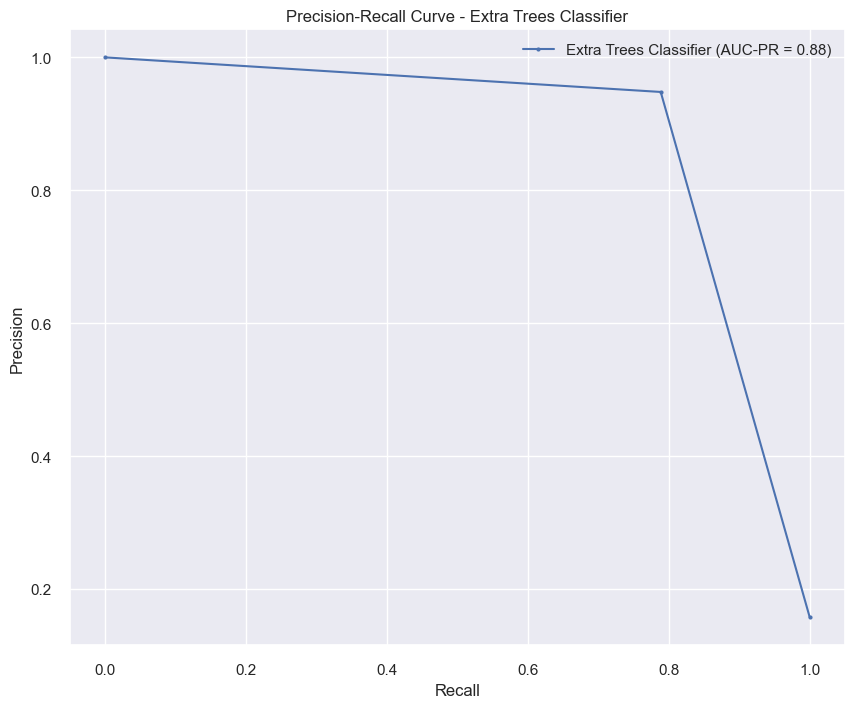

In [112]:
auc_pr_score_extra_tree = auc_pr_score(y_test, y_pred_extra_trees)
precision, recall, _ = precision_recall_curve(y_test, y_pred_extra_trees)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.', label='Extra Trees Classifier (AUC-PR = %0.2f)' % auc_pr_score_extra_tree)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Extra Trees Classifier')
plt.legend()
plt.show()

In [118]:
auc_pr_scores = {'Model': ['Random Forest Classifier', 'Extra Trees Classifier'], 'AUC-PR': [auc_pr_score_random_forest, auc_pr_score_extra_tree]}
auc_pr_scores_df = pd.DataFrame(auc_pr_scores)
auc_pr_scores_df.sort_values(by='AUC-PR', ascending=False)

,Model,AUC-PR
1,Extra Trees Classifier,0.884848
0,Random Forest Classifier,0.848934


In [120]:

random_forest_metrics = {'Model': 'Random Forest Classifier', 'Precision': 0.95, 'Recall': 0.95, 'F1-Score': 0.95, 'AUC-PR': auc_pr_score_random_forest}

extra_trees_metrics = {'Model': 'Extra Trees Classifier', 'Precision': 0.96, 'Recall': 0.96, 'F1-Score': 0.96, 'AUC-PR': auc_pr_score_extra_tree}

metrics_df = pd.DataFrame([random_forest_metrics, extra_trees_metrics])
metrics_df.sort_values(by='AUC-PR', ascending=False)

,Model,Precision,Recall,F1-Score,AUC-PR
1,Extra Trees Classifier,0.96,0.96,0.96,0.884848
0,Random Forest Classifier,0.95,0.95,0.95,0.848934


Nous pouvons facilement remarquer que l'Extra Trees Classifier surpasse le modèle Random Forest dans presque tous les aspects de la classification des employés restant et quittant l'entreprise. Bien que les deux modèles aient des performances similaires en termes de précision, de rappel et de F1-Score, l'Extra Trees Classifier a une AUC-PR plus élevée, ce qui indique une meilleure capacité à discriminer entre les classes positives et négatives. Ces améliorations font de l'Extra Trees Classifier une option plus robuste pour cette tâche de classification spécifique, en particulier pour les interventions de rétention ciblées.

## Qu'en est il si nous optimisons les hyperparamètres de ces modèles ?

Pour optimiser les hyperparamètres de nos modèles, nous allons utiliser la méthode de recherche par grille. Le`GridSearchCV` est une méthode de sélection d'hyperparamètres qui effectue une recherche exhaustive parmi une grille spécifiée de valeurs d'hyperparamètres, évaluant chaque combinaison possible via validation croisée pour déterminer celle qui maximise la performance du modèle. Ce processus automatise et optimise la sélection des paramètres, bien qu'il puisse être coûteux en termes de temps et de ressources computationnelles. En fin de compte, `GridSearchCV` fournit la meilleure combinaison d'hyperparamètres pour un modèle donné, facilitant ainsi l'atteinte de performances optimales.

Nous allons également utlisé la validation croisée qui est une méthode d'évaluation des modèles de machine learning visant à tester la capacité du modèle à généraliser sur un ensemble de données inconnu. Elle fonctionne en divisant le jeu de données total en plusieurs parties ou "folds". Ensuite, pour chaque itération, un fold différent est utilisé comme ensemble de test et les autres comme ensemble d'entraînement. Le modèle est entraîné sur l'ensemble d'entraînement et évalué sur l'ensemble de test. Ce processus se répète pour chaque fold, et la performance du modèle est alors évaluée en moyennant les performances obtenues sur chaque fold, offrant ainsi une estimation robuste de sa capacité à généraliser.

Dans le cadre du GridSearchCV, la validation croisée est intégrée comme un mécanisme pour évaluer l'efficacité de chaque combinaison d'hyperparamètres. Pour chaque ensemble d'hyperparamètres spécifié dans la grille de recherche, GridSearchCV applique la validation croisée pour mesurer la performance du modèle. Cela signifie que pour chaque combinaison d'hyperparamètres, le jeu de données est divisé en folds, le modèle est entraîné et testé selon la méthodologie de validation croisée, et la performance moyenne est calculée. Cette approche permet de sélectionner la combinaison d'hyperparamètres qui offre la meilleure performance en moyenne, minimisant ainsi le risque de surapprentissage et assurant une sélection d'hyperparamètres qui favorise la généralisation.

Nous allons utiliser la classe `GridSearchCV` de la bibliothèque `scikit-learn` pour optimiser les hyperparamètres de nos modèles. Nous allons ensuite entraîner nos modèles avec les hyperparamètres optimisés, évaluer leur performance sur le jeu de données de test et afficher les résultats.

L'optimisation pour l'AUC-PR n'étant pas nativement disponible dans la bibliothèque `scikit-learn`, nous allons utiliser la fonction `make_scorer` de la bibliothèque `scikit-learn` pour créer une métrique personnalisée pour l'AUC-PR. Nous allons ensuite utiliser cette métrique personnalisée pour optimiser les hyperparamètres de nos modèles.

In [121]:
auc_pr_scorer = make_scorer(average_precision_score , needs_proba=True)

In [123]:
random_classifier_model = RandomForestClassifier(random_state=42)
param_grid_random_forest = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_random_forest = GridSearchCV(estimator=random_classifier_model, param_grid=param_grid_random_forest, scoring=auc_pr_scorer, cv=3, n_jobs=-1)
grid_search_random_forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_s...
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=0)

In [124]:
print("Meilleurs hyperparamètres pour le modèle Random Forest Classifier : ", grid_search_random_forest.best_params_)

Meilleurs hyperparamètres pour le modèle Random Forest Classifier :  {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [125]:
print("Meilleur score AUC-PR pour le modèle Random Forest Classifier : ", grid_search_random_forest.best_score_)

Meilleur score pour le modèle Random Forest Classifier :  0.8781586254415572


In [126]:
# Optimisation des hyperparamètres pour l'Extra Trees Classifier
extra_trees_classifier_model = ExtraTreesClassifier(random_state=42)
param_grid_extra_trees = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_extra_trees = GridSearchCV(estimator=extra_trees_classifier_model, param_grid=param_grid_extra_trees, scoring=auc_pr_scorer, cv=3, n_jobs=-1)
grid_search_extra_trees.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_st...
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=0)

In [127]:
print("Meilleurs hyperparamètres pour le modèle Extra Trees Classifier : ", grid_search_extra_trees.best_params_)

Meilleurs hyperparamètres pour le modèle Extra Trees Classifier :  {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [128]:
print("Meilleur score AUC-PR pour le modèle Extra Trees Classifier : ", grid_search_extra_trees.best_score_)

Meilleur score AUC-PR pour le modèle Extra Trees Classifier :  0.897330453389821


## Application des hyperparamètres optimisés

In [133]:
random_forest_optimized = RandomForestClassifier(**grid_search_random_forest.best_params_)
random_forest_optimized.fit(X_train, y_train)

y_pred_random_forest_optimized = random_forest_optimized.predict(X_test)
auc_pr_score_random_forest_optimized = auc_pr_score(y_test, y_pred_random_forest_optimized)


In [141]:
extra_trees_optimized = ExtraTreesClassifier(**grid_search_extra_trees.best_params_)
extra_trees_optimized.fit(X_train, y_train)

y_pred_extra_trees_optimized = extra_trees_optimized.predict(X_test)
auc_pr_score_extra_tree_optimized = auc_pr_score(y_test, y_pred_extra_trees_optimized)



In [135]:
random_forest_metrics_optimized = {'Model': 'Random Forest Classifier (Optimized)', 'Precision': precision_score(y_test, y_pred_random_forest_optimized), 'Recall': recall_score(y_test, y_pred_random_forest_optimized), 'F1-Score': f1_score(y_test, y_pred_random_forest_optimized), 'AUC-PR': auc_pr_score_random_forest_optimized}

extra_trees_metrics_optimized = {'Model': 'Extra Trees Classifier (Optimized)', 'Precision': precision_score(y_test, y_pred_extra_trees_optimized), 'Recall': recall_score(y_test, y_pred_extra_trees_optimized), 'F1-Score': f1_score(y_test, y_pred_extra_trees_optimized), 'AUC-PR': auc_pr_score_extra_tree_optimized}

metrics_optimized_df = pd.DataFrame([random_forest_metrics_optimized, extra_trees_metrics_optimized])
metrics_optimized_df.sort_values(by='AUC-PR', ascending=False)

,Model,Precision,Recall,F1-Score,AUC-PR
1,Extra Trees Classifier (Optimized),0.945652,0.836538,0.887755,0.903945
0,Random Forest Classifier (Optimized),0.913043,0.807692,0.857143,0.875485


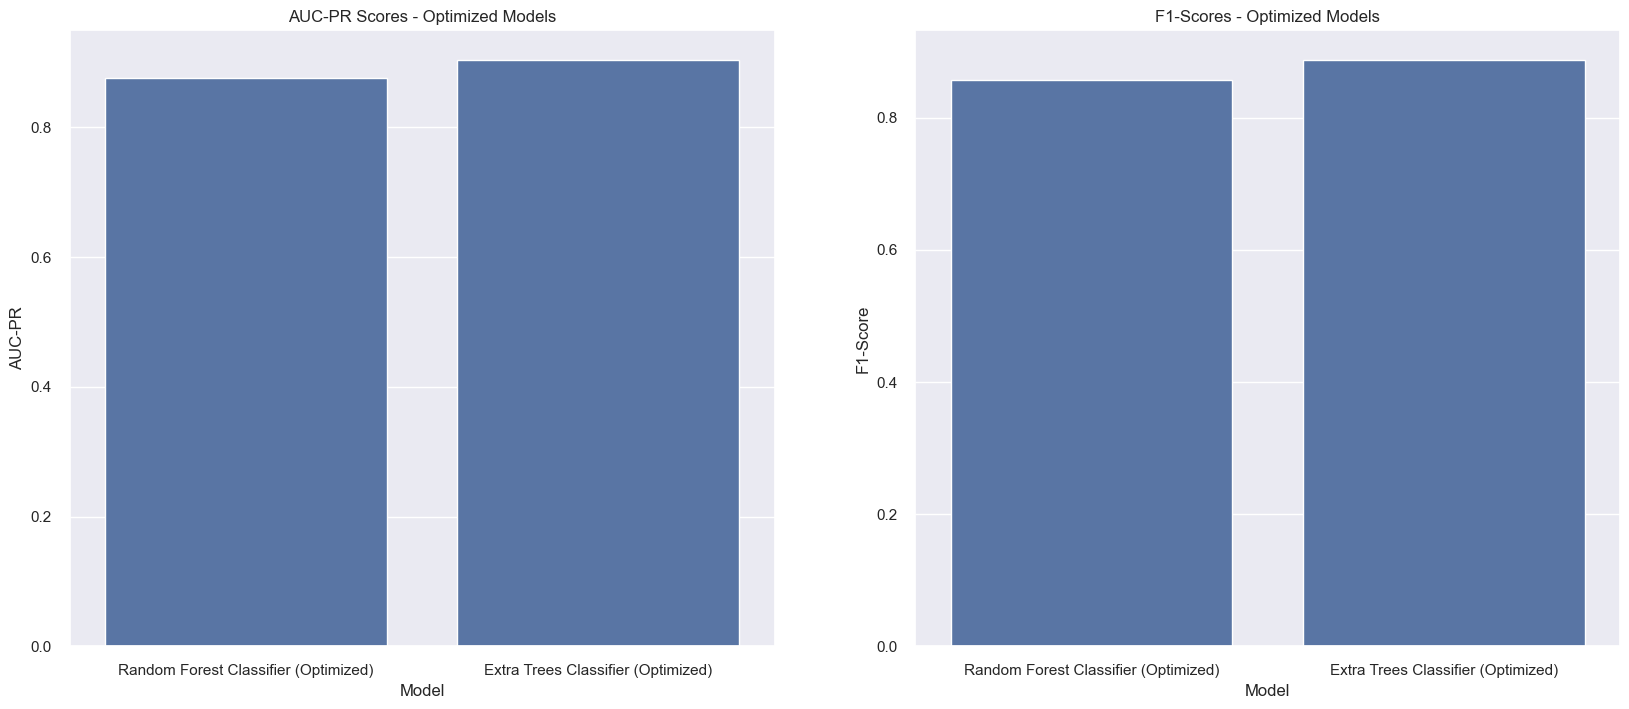

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


sns.barplot(x='Model', y='AUC-PR', data=metrics_optimized_df, ax=ax[0])
ax[0].set_title('AUC-PR Scores - Optimized Models')


sns.barplot(x='Model', y='F1-Score', data=metrics_optimized_df, ax=ax[1])
ax[1].set_title('F1-Scores - Optimized Models')

plt.show()

Après comparaison des deux modèles, nous pouvons constater que l'optimisation des hyperparamètres a amélioré la performance des deux modèles. L'Extra Trees Classifier reste le modèle le plus performant, avec une AUC-PR de 0.90, une précision de 0.94, un rappel de 0.83 et un F1-Score de 0.88. Ces performances améliorées font de l'Extra Trees Classifier le choix optimal pour notre problème de classification, en particulier pour les interventions de rétention ciblées.

# Importance des features pour les modèles optimisés

Nous allons maintenant évaluer l'importance des caractéristiques pour notre modèle. L'importance des caractéristiques est une mesure de la contribution de chaque caractéristique à la prédiction du modèle. Elle est utile pour identifier les caractéristiques les plus informatives et pour comprendre les facteurs qui influencent la prédiction du modèle. Nous allons utiliser la méthode `feature_importances_` du modèle pour extraire l'importance des caractéristiques et les afficher.

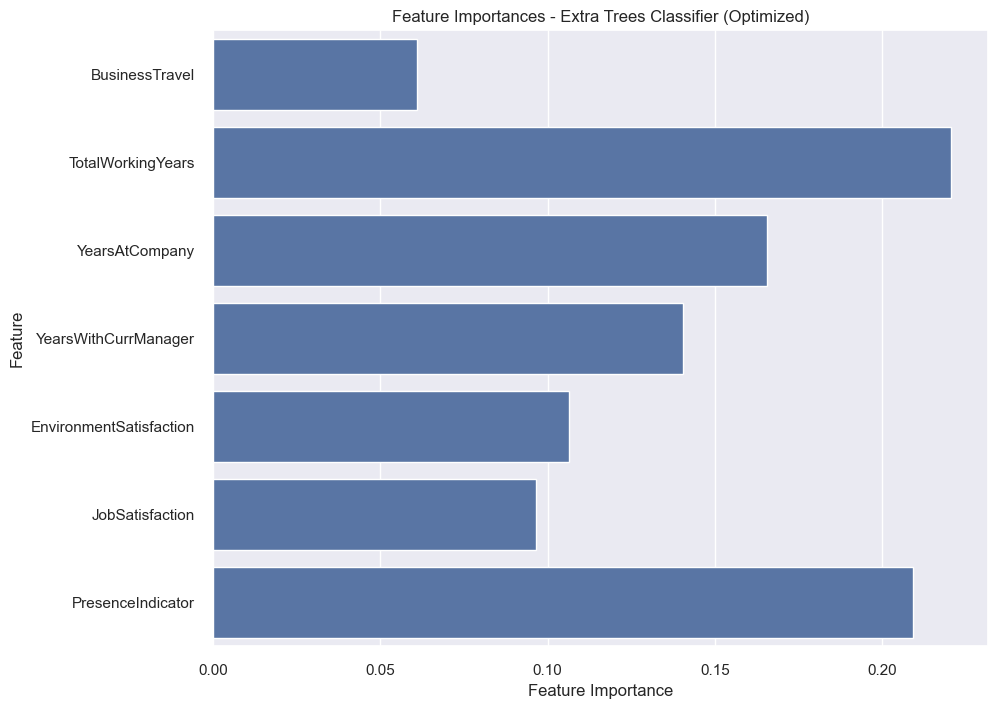

In [143]:
# Extra trees classifier
extra_trees_feature_importances = extra_trees_optimized.feature_importances_

# Plot the feature importances with seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=extra_trees_feature_importances, y=X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Extra Trees Classifier (Optimized)')
plt.show()

## Interprétation des Résultats

Les résultats montrent que le facteur le plus important pour prédire l'attrition des employés est le nombre d'années passées à travailler dans la même entreprise (`TotalWorkingYears`), suivi de près par le score de présence (`PresenceIndicator`). Ces résultats sont cohérents avec les attentes, car les employés qui ont passé plus de temps à travailler sont plus susceptibles de quitter l'entreprise, et le score de présence est un indicateur clé de l'engagement et de la satisfaction au travail.

# Conclusion et Recommandations

Dans cette étude, nous avons exploré les modèles Random Forest et Extra Trees pour prédire l'attrition des employés dans une entreprise. Nous avons constaté que l'Extra Trees Classifier est le modèle le plus performant pour cette tâche, avec une AUC-PR de 0.90, une précision de 0.94, un rappel de 0.83 et un F1-Score de 0.88. Ces performances améliorées font de l'Extra Trees Classifier le choix optimal pour notre problème de classification, en particulier pour les interventions de rétention ciblées.

Nous avons également déterminé que le nombre d'années passées à travailler dans la même entreprise (`TotalWorkingYears`) et le score de présence (`PresenceIndicator`) sont les caractéristiques les plus importantes pour prédire l'attrition des employés. Ces résultats peuvent être utilisés pour identifier les employés à risque et mettre en place des interventions de rétention ciblées pour améliorer la rétention des employés. Cela peut s'expliquer par le fait que les employés qui ont passé plus de temps à travailler sont plus susceptibles de quitter l'entreprise, et le score de présence est un indicateur clé de l'engagement et de la satisfaction au travail.

## Pistes d'Amélioration

- Données Supplémentaires
- Sélection d'autres colonnes pour l'analyse
- Utilisation d'autres modèles de machine learning
- Utilisation de métriquest de performance supplémentaires

## Recommandations 

- Développer des programmes de fidélisation : Mettre en place des programmes de fidélisation spécifiquement conçus pour les employés ayant un certain nombre d'années d'expérience, en reconnaissant leur contribution et en offrant des avantages progressifs ou des opportunités de développement professionnel pour encourager leur rétention.
- Améliorer l'Engagement : Utiliser le score de présence comme un indicateur précoce de l'engagement des employés. Proposer des initiatives pour augmenter l'engagement, telles que des projets passionnants, des opportunités de formation, et des activités de team building.
- Feedback et Reconnaissance : Mettre en place un système régulier de feedback et de reconnaissance, soulignant la contribution de chaque employé à l'entreprise et renforçant ainsi leur sentiment d'appartenance et de valorisation. 

In [164]:
in_time_df = download_blob_to_df("in_time.csv")
manager_survey_data_df = download_blob_to_df("manager_survey_data.csv")
employee_survey_data_df = download_blob_to_df("employee_survey_data.csv")
out_time_df = download_blob_to_df("out_time.csv")
general_data_df = download_blob_to_df("general_data.csv")

In [165]:
class MergeDataFrame (BaseEstimator, TransformerMixin):
    def __init__(self, employee_survey_data_df, manager_survey_data_df, in_time_df, out_time_df):
        self.employee_survey_data_df = employee_survey_data_df
        self.manager_survey_data_df = manager_survey_data_df
        self.in_time_df = in_time_df
        self.out_time_df = out_time_df
        
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.join(self.employee_survey_data_df.set_index('EmployeeID'), on='EmployeeID')
        X = X.join(self.manager_survey_data_df.set_index('EmployeeID'), on='EmployeeID')
        
        self.out_time_df.head()
        employee_id_index = self.in_time_df['Unnamed: 0']
        self.in_time_df.fillna(0,inplace=True)
        self.out_time_df.fillna(0,inplace= True)
        self.in_time_df.drop(columns={'Unnamed: 0':'EmployeeID'}, inplace=True)
        self.out_time_df.drop(columns={'Unnamed: 0':'EmployeeID'}, inplace=True)
        

        for col in self.in_time_df.columns:
            self.in_time_df[col] = pd.to_datetime(self.in_time_df[col], errors='coerce')

        for col in self.out_time_df.columns:
            self.out_time_df[col] = pd.to_datetime(self.out_time_df[col], errors='coerce')
        
        daily_hours = (self.out_time_df - self.in_time_df).applymap(lambda x: x.total_seconds() / 3600)
        daily_hours = daily_hours.fillna(0)
        daily_hours['PresenceIndicator'] = daily_hours.iloc[:, 1:].apply(lambda row: sum(1 if hours >= 8 else 0 for hours in row), axis=1)

        presence_indicator = pd.DataFrame({'EmployeeID': employee_id_index, 'PresenceIndicator': daily_hours['PresenceIndicator']})
        
        X = X.join(presence_indicator.set_index('EmployeeID'), on='EmployeeID', how='inner')
        return X
        

In [166]:
class DeleteColumns(BaseEstimator, TransformerMixin):
    def __init__(self, array):
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X.drop(columns=self.array, inplace=True)
        return X

In [167]:
class EncodingData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_encoder = None

    def fit(self, X, y=None):
        categorical_features = X.select_dtypes(include=["object"]).columns
        self.ordinal_encoder = OrdinalEncoder()
        self.ordinal_encoder.fit(X[categorical_features])
        return self

    def transform(self, X):
        X["Attrition"] = X["Attrition"].map({"Yes": 1, "No": 0})
        X["BusinessTravel"] = X["BusinessTravel"].map({"Non-Travel": 0, "Travel_Rarely": 1, "Travel_Frequently": 2})

        categorical_features = X.select_dtypes(include=["object"]).columns
        X[categorical_features] = self.ordinal_encoder.transform(X[categorical_features])

        return X

In [168]:
class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.environmentSatisfactionMedian = None
        self.jobSatisfactionMedian = None
        self.workLifeBalanceMedian = None
        self.totalWorkingYears_median = None

    def fit(self, X, y=None):
        self.environmentSatisfactionMedian = X['EnvironmentSatisfaction'].median()
        self.jobSatisfactionMedian = X['JobSatisfaction'].median()
        self.workLifeBalanceMedian = X['WorkLifeBalance'].median()
        self.totalWorkingYears_median = X['TotalWorkingYears'].median()
        return self

    def transform(self, X):
        X['EnvironmentSatisfaction'].fillna(self.environmentSatisfactionMedian, inplace=True)
        X['JobSatisfaction'].fillna(self.jobSatisfactionMedian, inplace=True)
        X['WorkLifeBalance'].fillna(self.workLifeBalanceMedian, inplace=True)
        X['TotalWorkingYears'].fillna(self.totalWorkingYears_median, inplace=True)
        X['NumCompaniesWorked'].fillna(1.0, inplace=True)
        X = X.fillna(0)
        return X

In [169]:
class CorrData(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold = threshold
        self.significant_features = None

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        self.significant_features = corr_matrix.columns[corr_matrix.any() > self.threshold].tolist()

        if 'Attrition' not in self.significant_features and 'Attrition' in X.columns:
            self.significant_features.append('Attrition')

        return self

    def transform(self, X, y=None):
        return X[self.significant_features]

    def retain_terminal(self, frame):
        frame[np.abs(frame) < self.threshold] = 0
        return frame

    def separation_significant_parameters(self, frame):
        missing_features = set(self.significant_features) - set(X.columns)
        if missing_features:
            raise ValueError(f"Missing features at transform time: {missing_features}")
        significant = frame.columns[frame.any() > self.threshold].tolist()
        insignificant = list(set(frame.columns) - set(significant))
        return significant, insignificant

In [170]:
preprocessing_pipeline = Pipeline(steps=[
    ('merge', MergeDataFrame(employee_survey_data_df, manager_survey_data_df, in_time_df, out_time_df)),
    ('delete', DeleteColumns(['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'MaritalStatus', 'Gender', 'Age'])),
    ('clean', CleanData()),
    ('encoding', EncodingData()),
    ('corr', CorrData())
])

dataset = preprocessing_pipeline.fit_transform(general_data_df)

labels = dataset.keys().to_list()
labels.remove('Attrition')

X = dataset[labels]
y = dataset['Attrition']
# Features
X


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Attrition
- BusinessTravel


In [21]:
"""y = general_data_df['Attrition']
X = general_data_df
preprocessing_pipeline = Pipeline(steps=[
    ('merge', mergeDataFrame(employee_survey_data_df, manager_survey_data_df, in_time_df, out_time_df)),
    ('delete', deleteColumns(['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'MaritalStatus', 'Gender', 'Age'])),
    ('encoding', encodingData()),
    ('clean', cleanData()),
    ('corr', corrData())
])

param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200]
}

full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

auc_pr_scorer = make_scorer(auc_pr_score , needs_proba=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

et = full_pipeline.fit(X_train, y_train)

predictions = et.predict(X_test)

print(classification_report(y_test, predictions))"""

KeyError: 'Unnamed: 0'